# Making a package for systematics analysis

The idea of this notebook is to take a fully-converged MCMC fit and produce a package of data files suitable for analyzing the unmodelled systematics remaining in the data. It should contain:

* The best-fit parameter names, values, and uncertainties (covariance matrix)
* Names, values, and uncertainties on any parameters obtained by linear fitting
* Names, values, and uncertainties for derived parameters
* The astrometric parameters that went into the calculation
* The settings used in the fitting
* Residuals of the fitting, in the form of a matrix with columns time, residual (phase), uncertainty
* Derivatives of the residuals with respect to all fitted parameters
* Derivatives of an imaginary uniformly sampled data set with respect to all fitted parameters

This package should contain the information needed to do a purely frequentist test of the SEP. We therefore want to be able to produce several variants, as needed:

* `GR` - A plain-GR fit
* `GRplus` - A plain-GR fit but including derivatives with respect to GR-violation parameters
* `heavysimple` - A full GR_violation fit


In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from glob import glob
import os
import time
import cPickle as pickle
import joblib

import scipy.linalg
import scipy.stats

import emcee
import numdifftools

import kepler
import threebody

In [3]:
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.viridis()

In [186]:
name = "primary"
#name = "lowfreq"
#name = "newton"
#name = "dailyDM"
#name = "WSRT"
#name = "AO"
#name = "GBT"
#name = "GR"
#name = "fake"
#name = "fake_noSR"
#name = "fake_noSR_noGR"
#name = "nonzerodelta"


d = os.path.join("derivative-runs", name)
params = pickle.load(open(os.path.join(d,"params.pickle")))
F = threebody.Fitter(**params)
F.best_parameters = pickle.load(
    open(os.path.join(d,"best_parameters.pickle")))
nl_der = {}
for p in F.parameters:
    nl_der[p] = np.load(os.path.join(d,"%s.npy" % p))
params

{'dmx_span': (144.3, 509.55, 874.8, 1240.05, 1605.3, 1970.55),
 'efac': 1,
 'fdn_range': (1, 5),
 'files': 'tuned2_aligned_pulses_1400_nosun2',
 'fit_pm': True,
 'fit_pos': True,
 'fit_px': True,
 'kopeikin': False,
 'linear_dm': False,
 'linear_jumps': True,
 'parfile': '0337_de435_grpaper.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'toa_mode': 'pipeline',
 'tzrmjd_middle': 'auto',
 'variable_dm': True,
 'variable_ipm': True}

In [187]:
F.best_parameters

{'acosi_i': 1.4895541513424564899,
 'acosi_o': 91.36103723804699249,
 'asini_i': 1.2175252779716744885,
 'asini_o': 74.672633134978249329,
 'dbeta': 0.0015296055665143897265,
 'delta': -1.0853003777088741092e-06,
 'delta_lan': 2.1991360118761438107e-06,
 'dgamma': -1.3379539468949432047e-05,
 'eps1_i': 0.00068826206308475963605,
 'eps1_o': 0.035185965814842112529,
 'eps2_i': -9.1395416831860648936e-05,
 'eps2_o': -0.0034630696957737554409,
 'pb_i': 1.6293934166924090081,
 'pb_o': 327.25688557208299206,
 'q_i': 0.13740557041242769519,
 'tasc_i': 0.4077166413697450023,
 'tasc_o': 313.93515997689802044}

In [188]:
F.goodness_of_fit(F.best_parameters)

36705.644001652699409

In [189]:
orbit = F.compute_orbit(F.best_parameters)
orbit

{'initial_values': array([  1.13350308e+02,   2.15553549e+01,   1.76181042e+01,
          6.75799047e+00,   1.69183171e+00,   1.38279321e+00,
          1.43599079e+00,   1.13348091e+02,   3.38939613e+01,
          2.77033805e+01,  -5.46088454e+01,   1.68956154e+00,
          1.38093763e+00,   1.97313134e-01,  -4.51944662e+02,
         -9.18878101e+01,  -7.51039957e+01,   2.61358197e+00,
         -6.74450899e+00,  -5.51252297e+00,   4.09641005e-01,
          0.00000000e+00]),
 'n_evaluations': 1592160,
 'parameter_dict': {'acosi_i': 1.4895541513424564899,
  'acosi_o': 91.36103723804699249,
  'asini_i': 1.2175252779716744885,
  'asini_o': 74.672633134978249329,
  'dbeta': 0.0015296055665143897265,
  'delta': -1.0853003777088741092e-06,
  'delta_lan': 2.1991360118761438107e-06,
  'dgamma': -1.3379539468949432047e-05,
  'eps1_i': 0.00068826206308475963605,
  'eps1_o': 0.035185965814842112529,
  'eps2_i': -9.1395416831860648936e-05,
  'eps2_o': -0.0034630696957737554409,
  'general': True,


36705.0456386 27110


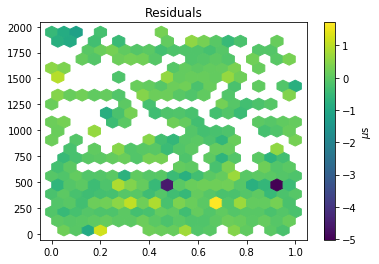

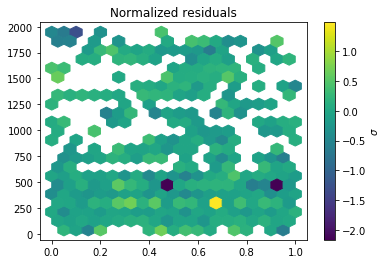

In [190]:
residuals = F.residuals()
plt.hexbin(
    ((F.mjds-F.base_mjd-F.best_parameters['tasc_i'])/F.best_parameters['pb_i'])%1, 
    F.mjds,
    C=residuals/F.reference_f0*1e6, gridsize=20)
plt.title("Residuals")
plt.colorbar().set_label(r"$\mu$s")
plt.figure()
plt.hexbin(
    ((F.mjds-F.base_mjd-F.best_parameters['tasc_i'])/F.best_parameters['pb_i'])%1, 
    F.mjds,
    C=residuals/F.phase_uncerts, gridsize=20)
plt.title("Normalized residuals")
plt.colorbar().set_label(r"$\sigma$")

print np.sum((residuals/F.phase_uncerts)**2), len(F.mjds)

In [191]:
M, linear_parameters = F.compute_linear_matrix()
linear_parameters

['DM_0001',
 'DM_0002',
 'DM_0003',
 'DM_0004',
 'FD1',
 'FD2',
 'FD3',
 'FD4',
 'IPM_0000',
 'IPM_0001',
 'IPM_0002',
 'IPM_0003',
 'IPM_0004',
 'd_DECJ',
 'd_PMDEC',
 'd_PMRA',
 'd_PX',
 'd_RAJ',
 'f0',
 'f1',
 'j_GBT_1400',
 'j_WSRT_1400',
 'phase']

In [192]:
M.shape

(27110, 23)

In [193]:
derivatives = {}

In [194]:
for i, p in enumerate(linear_parameters):
    derivatives[p] = M[:,i]

In [195]:
derivatives.update(nl_der)

## Annotating TOAs

In [196]:
extra = derivatives.copy()

toa_info = F.annotated_toas(extra, residuals=residuals)

## Exporting the information


In [197]:
np.savez_compressed(
    "systematics-package-%s.npz" % name,
    fitter_params=params,
    best_parameters=F.best_parameters,
    residuals=residuals,
    telescopes=F.tels,
    telescope_list=F.tel_list,
    orbit=orbit,
    times=F.mjds,
    base_mjd=F.base_mjd,
    phase_uncerts=F.phase_uncerts,
    linear_parameters=linear_parameters,
    derivatives=derivatives,
    toa_info=toa_info,
    )

In [198]:
d = dict(
    fitter_params=params,
    best_parameters=F.best_parameters,
    residuals=residuals,
    telescopes=F.tels,
    telescope_list=F.tel_list,
    f0=F.reference_f0,
    efacs=params['efac'],
    orbit=orbit,
    times=F.mjds,
    base_mjd=F.base_mjd,
    phase_uncerts=F.phase_uncerts,
    linear_parameters=linear_parameters,
    derivatives=derivatives,
    toa_info=toa_info,
    )
with open("systematics-package-%s.pickle" % name,"wb") as f:
    pickle.dump(d,f)

In [201]:
threebody.write_t2_toas(F.files+"_"+name+".tim",
                        toa_info)


In [208]:
n = F.files+"_"+name+"_residuals.csv"
col_names = []
cols = []

col_names.append("MJD (approx)")
cols.append(F.mjds+F.base_mjd)
col_names.append("residual")
cols.append(residuals)
col_names.append("uncertainty (phase)")
cols.append(F.phase_uncerts)
for k, v in derivatives.items():
    col_names.append(k)
    cols.append(v)
    
np.savetxt(n, 
           np.array(cols).T, 
           header=",\t".join(col_names),
           delimiter=",\t")

## Checking the quality of the derivatives and the fit

In [154]:
print F.parameters

['asini_i', 'pb_i', 'eps1_i', 'eps2_i', 'tasc_i', 'acosi_i', 'q_i', 'asini_o', 'pb_o', 'eps1_o', 'eps2_o', 'tasc_o', 'acosi_o', 'delta_lan', 'delta', 'dgamma', 'dbeta']


In [155]:
params = F.parameters + linear_parameters
#exclude = ["delta","dbeta","dgamma"]
exclude = []
trim_params = [p for p in params if p not in exclude]
Abig = np.array([derivatives[p] 
                 for p in trim_params], 
                dtype=np.longdouble).T
#print(Abig.shape)
r = threebody.lstsq_with_errors(Abig, residuals, F.phase_uncerts)
for i,p in enumerate(trim_params):
    print p, threebody.fmt(r.x[i], r.uncerts[i])
print r.singular_values

asini_i 0(3)e-7
pb_i 0(7)e-7
eps1_i 0(2)e-7
eps2_i 0(18)e-9
tasc_i 0(7)e-8
acosi_i -1.4(19)e-4
q_i -2(5)e-6
asini_o 0(13)e-6
pb_o 0(11)e-5
eps1_o -2(5)e-8
eps2_o 0(16)e-8
tasc_o 0(11)e-5
acosi_o 0(12)e-3
delta_lan 0(9)e-7
delta 0(19)e-8
dgamma -1(3)e-2
dbeta -5(5)e-2
DM_0000 0(12)e1
DM_0001 0(12)e1
DM_0002 0(12)e1
DM_0003 0(12)e1
DM_0004 0(12)e1
DM_0005 0(12)e1
DM_0006 0(12)e1
DM_0007 0(12)e1
DM_0008 0(12)e1
DM_0009 0(12)e1
DM_0010 0(12)e1
FD1 0(10)e-1
FD2 0(9)e-1
FD3 0(5)e-1
FD4 0(15)e-2
IPM_0000 0(8)e0
IPM_0001 0(6)e1
IPM_0002 0(20)e0
IPM_0003 0(18)e1
IPM_0004 0(3)e1
IPM_0005 0(2)e2
IPM_0006 2(9)e1
IPM_0007 0(14)e1
IPM_0008 0(5)e1
IPM_0009 0(15)e2
IPM_0010 -3(9)e2
d_DECJ 0(5)e-6
d_PMDEC 0(20)e-10
d_PMRA 0(6)e-10
d_PX 1(8)e0
d_RAJ 0(11)e-7
f0 -2(4)e-9
f1 0(4)e-21
j_GBT_1400 1(5)e-6
j_WSRT_1400 0(10)e-6
phase 0(5)e-1
[  3.58012940e+00   2.47909219e+00   2.12470779e+00   1.88803998e+00
   1.84032225e+00   1.65160563e+00   1.60605222e+00   1.47497337e+00
   1.36253172e+00   1.31505583e+0

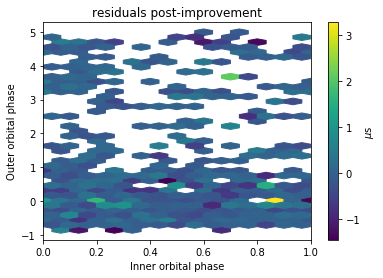

In [156]:
threebody.hexplot(F.best_parameters, F.mjds, 
                  r.residuals/F.reference_f0*1e6, 
                  gridsize=(15,20))
plt.colorbar(label=r"$\mu$s")
plt.title("residuals post-improvement")

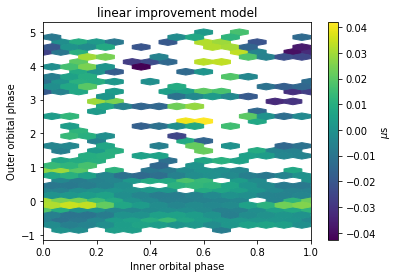

In [157]:
v = (residuals-r.residuals)
threebody.hexplot(F.best_parameters, F.mjds, 
                  v/F.reference_f0*1e6, 
                  gridsize=(15,20))
plt.colorbar(label=r"$\mu$s")
plt.title("linear improvement model")

In [158]:
bp = F.best_parameters.copy()
for p in F.parameters:
    i = params.index(p)
    bp[p] -= r.x[i]
pre = F.goodness_of_fit(F.best_parameters)
print "pre-improvement:", pre
post = F.goodness_of_fit(bp)
print "post-improvement:", post
if post<pre:
    with open("derivative-best-parameters.pickle","wb") as f:
        pickle.dump(bp, f)

pre-improvement: 35964.2426404
post-improvement: 319961.550896


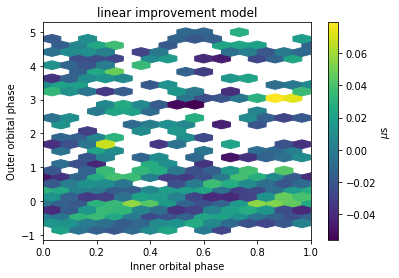

In [159]:
A = np.array([derivatives[p] 
              for p in derivatives.keys() if p!="delta"]).T
b = 1e-6*derivatives["delta"]
r = threebody.lstsq_with_errors(A, b, F.phase_uncerts)
v = r.residuals
threebody.hexplot(F.best_parameters, F.mjds, 
                  v/F.reference_f0*1e6, 
                  gridsize=(15,15))
plt.colorbar(label=r"$\mu$s")
plt.title("linear improvement model")